In [1]:
# https://www.kaggle.com/shakedzy/alone-in-the-woods-using-theil-s-u-for-survival
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
# https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import math
from collections import Counter
# import numpy as np
import seaborn as sns
# import pandas as pd
import scipy.stats as ss
# import matplotlib.pyplot as plt
import sklearn.preprocessing as sp
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from subprocess import check_output


#Dataframe Visual Settings
pd.set_option('display.max_rows',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth',400)

def PIN_col(x):
    if("POS PURCHASE Non-PIN" in x):
        return "POS PURCHASE Non-PIN"
    elif("POS PURCHASE with PIN" in x):
        return "POS PURCHASE with PIN"
    elif("VENMO" in x):
        return "VENMO"
    else:
        return "Other"
    
def remove_payment_method(x):
    if("POS PURCHASE Non-PIN" in x):
        return x.split("POS PURCHASE Non-PIN")[1]
    elif("POS PURCHASE with PIN" in x):
        return x.split("POS PURCHASE with PIN")[1]
    else:
        return x

def middle_words(x):
    if(len(x) > 2):
        return x[1:-1]
    else:
        return "N/A"

def clean_bank_statement_file(filename):
    """
    Extract, modify & clean bank statement raw file for neater format
    """
    #Cleaning data
    # csv_file = '\Bank Statements\'' + filename
    df = pd.read_csv(filename,
                     usecols=['Transaction Number','Date','Memo','Amount Debit','Amount Credit'],
                     skiprows=3)
    
    df.fillna({'Amount Debit':0, 'Amount Credit':0},inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
    df.sort_values(by=['Date'],ascending=False,ignore_index=True,inplace=True)
    df['Memo'].fillna('Default',inplace=True)
    df['Transaction Number'] = df['Transaction Number'].apply(lambda x: x.split('**')[1])
    df['Purchase Date'] = df[df['Memo'].str.contains('1574 ',na=False)]['Memo']\
        .apply(lambda x: x.split('1574 ')[1])
    df['Purchase Date'] = pd.to_datetime(df['Purchase Date'],format = '%m/%d %H:%M')
    df['Purchase Date'] = df['Purchase Date']+pd.DateOffset(years=120)
    df.loc[df['Purchase Date'].isna(),'Purchase Date'] = df['Date'].copy()
    df['Memo'] = df['Memo'].apply(lambda x: x.split('*****')[0])
    df['Content'] = df['Transaction Number'] + ' ' + df['Memo']
    df['Amount'] = df['Amount Debit'].astype(float) + df['Amount Credit'].astype(float)
    df['Category'] = 'Default'
    df['Payment_Method'] = df['Content'].apply(lambda x: PIN_col(x))
    df["Content"] = df["Content"].apply(lambda x: remove_payment_method(x))
    df['Purchase Time'] = [d.time() for d in df['Purchase Date']]
    df['Purchase Date'] = [d.date() for d in df['Purchase Date']]
    df['Verification Date'] = df['Date'].copy()
    df['Content_Word_Length'] = df['Content'].apply(lambda x: len(x.split(' ')))
    df['First_Word'] = df['Content'].apply(lambda x: x.split(' ')[0])
    df['Last_Word'] = df['Content'].apply(lambda x: x.split(' ')[-1])
    df['Middle_Words'] = df['Content'].apply(lambda x: middle_words(x.split(' ')))
    df.drop(df[df['Content'].str.contains("INTERNET TRANSFER",na=False)].index,inplace=True)
    df.drop(df[df['Content'].str.contains('DDXXXX5941',na=False)].index, inplace=True)
    df.reset_index(drop=True,inplace=True)
    df.drop(['Date','Transaction Number','Memo','Amount Debit','Amount Credit'],
            axis=1,inplace=True)
    df.sort_values(by=['Purchase Date'],ascending=False, inplace=True)
    return df

def categorize(df):
    """
    For common transactions, categorize these early, and use to train a model
    """
    #Easier Categorization
    df.loc[df['Content'].str.contains("UBER EATS",na=False),'Category'] = 'Dining Out'
    df.loc[df['Content'].str.contains("HARRIS",na=False),'Category'] = 'Groceries'
    df.loc[df['Content'].str.contains("GIANT",na=False),'Category'] = 'Groceries'
    df.loc[df['Content'].str.contains("USAA",na=False),'Category'] = 'USAA Insurance'
    df.loc[df['Content'].str.contains("Accenture",na=False),'Category'] = 'Pay Check'
    df.loc[df['Content'].str.contains("XSPORT",na=False),'Category'] = 'Gym'
    df.loc[df['Content'].str.contains("DISTRICT MARTIAL ARTS",na=False),'Category'] = 'Gym'
    df.loc[df['Content'].str.contains("PARKING",na=False),'Category'] = 'Tolls/Uber/Metro/Parking'
    df.loc[df['Content'].str.contains("NAZRET",na=False),'Category'] = 'Dining Out'
    df.loc[df['Content'].str.contains("TAJ OF INDIA",na=False),'Category'] = 'Dining Out'
    df.loc[df['Content'].str.contains("DCPILLAR",na=False),'Category'] = 'Tithe'
    df.loc[df['Content'].str.contains("GOOGLE",na=False),'Category'] = 'Entertainment'
    df.loc[df['Content'].str.contains("VENMO/CASHOUT",na=False),'Category'] = 'Venmo Extra'
    df.loc[df['Content'].str.contains("CITGO",na=False),'Category'] = 'Gas'
    df.loc[df['Content'].str.contains("SHELL",na=False),'Category'] = 'Gas'
    df.loc[df['Content'].str.contains("PUPATELLA",na=False),'Category'] = 'Dining Out'
    df.loc[df['Content'].str.contains("GOOD COMPANY DONUT",na=False),'Category'] = 'Dining Out'
    df.loc[df['Content'].str.contains("STARBUCKS",na=False),'Category'] = 'Dining Out'
    df.loc[df['Content'].str.contains("UBER TRIP",na=False),'Category'] = 'Tolls/Uber/Metro/Parking'
    df.loc[df['Content'].str.contains("VERIZON",na=False),'Category'] = 'Utilities'
    df.loc[df['Content'].str.contains("WASHINGTON GAS",na=False),'Category'] = 'Utilities'
    df.loc[df['Content'].str.contains("ENERGY",na=False),'Category'] = 'Utilities'
    df.loc[df['Content'].str.contains("TOM COLEMAN",na=False),'Category'] = 'Phone'
    df.loc[df['Content'].str.contains("STDNT LOAN",na=False),'Category'] = 'Student Loans'
    df.loc[(df['Content'].str.contains("VENMO/PAYMENTWALTER COLEMAN Default",na=False)) &
           (df['Amount'] == -845),'Category'] = 'Rent'
    df.loc[df['Content'].str.contains("Margaret Coleman",na=False),'Category'] = 'Extra'
    df.loc[df['Content'].str.contains("Person-to-Person TransferPAYPAL",na=False),'Category'] = 'Extra'
    df.loc[df['Content'].str.contains("Tortas y Tacos",na=False),'Category'] = 'Dining Out'
    df.loc[df['Content'].str.contains("CROWNE PLAZA",na=False),'Category'] = 'Dining Out'
    df.loc[df['Content'].str.contains("Emmaus Family Couns",na=False),'Category'] = 'Medical'
    df.loc[df['Content'].str.contains("ADVANCED HEALTH CARE",na=False),'Category'] = 'Medical'
    df.loc[df['Content'].str.contains("AMZN Mktp",na=False),'Category'] = 'Misc'
    df.loc[df['Content'].str.contains("Amazon web services",na=False),'Category'] = 'Misc'
    df.loc[df['Content'].str.contains("ALDI",na=False),'Category'] = 'Groceries'
    df.loc[df['Content'].str.contains("FOOD LION",na=False),'Category'] = 'Groceries'
    df.loc[df['Content'].str.contains("Audible",na=False),'Category'] = 'Entertainment'
    df.loc[df['Content'].str.contains("PIZZA",na=False),'Category'] = 'Dining Out'
    df.loc[df['Content'].str.contains("CROWNE PLAZA",na=False),'Category'] = 'Dining Out'
    #set positive defaults to Misc
    df.loc[(df['Category'] == 'Default') & (df['Amount'] > 0), 'Category'] = 'Extra'
    df.loc[(df['Purchase Time'] == dt.time(0,0,0)) & (df['Category'] == 'Default') & \
             (df['First_Word'] != 'VENMO/PAYMENTWALTER'), 'Category'] = 'Misc'
    df.loc[(df['Category'] == 'Default') & (df['First_Word'] == 'SQ'), 'Category'] = 'Dining Out'
    df.loc[(df['Category'] == "Default") & (df["First_Word"] != "VENMO/PAYMENTWALTER"), "Category"] = "Misc"
    df.loc[df['Content'].str.contains("Pizza",na=False),'Category'] = 'Dining Out'
    df.loc[df['Content'].str.contains("Amzn",na=False),'Category'] = 'Misc'
    df.loc[df['Content'].str.contains("Pollo",na=False),'Category'] = 'Dining Out'
    df.loc[df['Content'].str.contains("VZ WIRELESS",na=False),'Category'] = 'Phone'
    df.loc[df['Content'].str.contains("PARKMOBILE",na=False),'Category'] = 'Tolls/Uber/Metro/Parking'
    return df 

def create_grand_file(directory):
    """
    Extract based on string file names
    """
    grand_df = pd.DataFrame()
    temp_df = pd.DataFrame()

    #Get list of files
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            temp_df = clean_bank_statement_file(filename)
            temp_df = categorize(temp_df)
            grand_df = pd.concat([grand_df,temp_df],ignore_index=True)
    
    return grand_df


In [62]:
class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.W = self.add_weight(name='W',
                      shape=(input_shape[-1], self.output_dim),
                      initializer='uniform',
                      trainable=True)
        self.P = self.add_weight(name='P',
                      shape=(input_shape[1], self.output_dim),
                      initializer='uniform',
                      trainable=True)
        self.w = self.add_weight(name='w',
                      shape=(input_shape[1], 1),
                      initializer='uniform',
                      trainable=True)
        self.p = self.add_weight(name='p',
                      shape=(input_shape[1], 1),
                      initializer='uniform',
                      trainable=True)
        super(T2V, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)
    
def T2V_NN(param, dim):
    
    inp = Input(shape=(dim,1))
    x = T2V(param['t2v_dim'], dim)(inp)
    x = LSTM(param['unit'], activation=param['act'])(x)
    x = Dense(1)(x)
    
    m = Model(inp, x)
    m.compile(loss='mse', optimizer=Adam(lr=param['lr']))
    
    return m
def NN(param, dim):
    
    inp = Input(shape=(dim,1))
    x = LSTM(param['unit'], activation=param['act'])(inp)
    x = Dense(1)(x)
    
    m = Model(inp, x)
    m.compile(loss='mse', optimizer=Adam(lr=param['lr']))
    
    return m

NameError: name 'Layer' is not defined

In [2]:
feb_df = pd.read_excel('FebruaryFormatted.xlsx')
mar_un = pd.read_csv('March2021.csv')
ult_df = pd.read_excel('bank_statements_categorized.xlsx')

In [11]:
# ult_df.drop('Unnamed: 0',axis=1,inplace=True)
feb_df.drop('Date',axis=1,inplace=True)

In [18]:
feb_df.columns == ult_df.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [13]:
feb_df.columns

Index(['Purchase Date', 'Content', 'Amount', 'Category', 'Payment_Method', 'Purchase Time', 'Verification Date', 'Content_Word_Length', 'First_Word', 'Last_Word', 'Middle_Words'], dtype='object')

In [16]:
feb_df = feb_df[['Purchase Date', 'Purchase Time', 'Payment_Method', 'Content', 'Amount', 'Verification Date',\
        'Content_Word_Length', 'First_Word', 'Last_Word', 'Middle_Words', 'Category']].copy()

In [17]:
ult_df = ult_df[['Purchase Date', 'Purchase Time', 'Payment_Method', 'Content', 'Amount', 'Verification Date',\
        'Content_Word_Length', 'First_Word', 'Last_Word', 'Middle_Words', 'Category']].copy()

In [7]:
ult_df

,Unnamed: 0,Purchase Date,Purchase Time,Payment_Method,Content,Amount,Verification Date,Category,Content_Word_Length,First_Word,Last_Word,Middle_Words
0,267,2021-01-29,1899-12-30 00:00:00,Other,USAA PC/PAYMENTWALTER COLEMAN Default,-187.68,2021-01-29,USAA Insurance,4,USAA,Default,"['PC/PAYMENTWALTER', 'COLEMAN']"
1,268,2021-01-27,1899-12-30 00:00:00,VENMO,VENMO/CASHOUTWALTER COLEMAN Default,669.80,2021-01-27,Venmo Extra,3,VENMO/CASHOUTWALTER,Default,['COLEMAN']
2,269,2021-01-21,1899-12-30 00:00:00,Other,"Accenture Federa/PAYRLL DEPColeman, Walter J",2099.81,2021-01-21,Pay Check,5,Accenture,J,"['Federa/PAYRLL', 'DEPColeman,', 'Walter']"
3,271,2021-01-20,1899-12-30 00:00:00,VENMO,VENMO/PAYMENTWALTER COLEMAN Default,-845.00,2021-01-20,Rent,3,VENMO/PAYMENTWALTER,Default,['COLEMAN']
4,270,2021-01-20,1899-12-30 00:00:00,VENMO,VENMO/PAYMENTWALTER COLEMAN Default,-48.22,2021-01-20,Utilities,3,VENMO/PAYMENTWALTER,Default,['COLEMAN']
5,272,2021-01-07,1899-12-30 00:00:00,Other,Pillar DC/Pillar DCPILLAR CHURCH OF WASHI,-339.23,2021-01-07,Tithe,6,Pillar,WASHI,"['DC/Pillar', 'DCPILLAR', 'CHURCH', 'OF']"
6,273,2021-01-06,1899-12-30 00:00:00,Other,"Accenture Federa/PAYRLL DEPColeman, Walter J",2262.00,2021-01-06,Pay Check,5,Accenture,J,"['Federa/PAYRLL', 'DEPColeman,', 'Walter']"
7,275,2021-01-06,1899-12-30 00:00:00,VENMO,VENMO/PAYMENTWALTER COLEMAN Default,-26.12,2021-01-06,Utilities,3,VENMO/PAYMENTWALTER,Default,['COLEMAN']
8,274,2021-01-06,1899-12-30 00:00:00,Other,Pillar DC/Pillar DCPILLAR CHURCH OF WASHI,-60.00,2021-01-06,Tithe,6,Pillar,WASHI,"['DC/Pillar', 'DCPILLAR', 'CHURCH', 'OF']"
9,276,2021-01-05,1899-12-30 00:00:00,Other,Mobile Check Deposit Default,175.00,2021-01-05,Extra,4,Mobile,Default,"['Check', 'Deposit']"


In [19]:
print(len(feb_df))
print(len(ult_df))

67
756


{'whiskers': [<matplotlib.lines.Line2D at 0x1abd14fc288>,
 'caps': [<matplotlib.lines.Line2D at 0x1abd152ac48>,
 'boxes': [<matplotlib.lines.Line2D at 0x1abd152a148>],
 'medians': [<matplotlib.lines.Line2D at 0x1abd153b408>],
 'fliers': [<matplotlib.lines.Line2D at 0x1abd153b848>],
 'means': []}

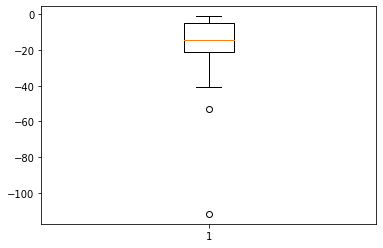

In [21]:
plt.boxplot(ult_df[ult_df['Category'] == 'Dining Out']['Amount'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1abd1e0eec8>,
 'caps': [<matplotlib.lines.Line2D at 0x1abd1e73ec8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1abd1e73148>],
 'medians': [<matplotlib.lines.Line2D at 0x1abd1e73fc8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1abd1e79bc8>],
 'means': []}

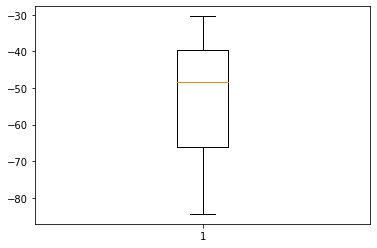

In [33]:
plt.boxplot(ult_df[(ult_df['Category'] == 'Groceries') & (ult_df['Amount'] < -30)]['Amount'])

In [ ]:
# ult df is the training data
# feb df without category is the testing data

# encode for time series and natural language

# use ult df to train decision tree model
# use said model to then predit (categorize) the bank statement cats

# compare predictions to actual feb categories
# see how effectively the model was, and what changes to the decision tree itself might be needed,
# or what additional features might've been needed

# also see how the model parses the data itself, and what features it uses as it selects categories

# if model is fairly sucessful, then use to categorize the march statements and test appropriately

# once the feb and march data are correctly formatted and categorized, not only can then be documented in budget
# but they can also be added to the grand data list of all formatted, categorized bank statements

In [34]:
feb_df

,Purchase Date,Purchase Time,Payment_Method,Content,Amount,Verification Date,Content_Word_Length,First_Word,Last_Word,Middle_Words,Category
0,2021-02-24,00:00:00,Other,VZ WIRELESS VE/VZW WEBPAYWALTER *COLEMAN,-104.20,2021-02-24,5,VZ,*COLEMAN,"['WIRELESS', 'VE/VZW', 'WEBPAYWALTER']",Phone
1,2021-02-24,00:00:00,Other,Pillar DC/Pillar DCPILLAR CHURCH OF WASHI,-310.97,2021-02-24,6,Pillar,WASHI,"['DC/Pillar', 'DCPILLAR', 'CHURCH', 'OF']",Tithe
2,2021-02-23,00:00:00,VENMO,VENMO/PAYMENTWALTER COLEMAN Default,-46.41,2021-02-23,3,VENMO/PAYMENTWALTER,Default,['COLEMAN'],Utilities
3,2021-02-22,00:00:00,Other,USAA PC/PAYMENTWALTER COLEMAN Default,-187.68,2021-02-22,4,USAA,Default,"['PC/PAYMENTWALTER', 'COLEMAN']",USAA Insurance
4,2021-02-22,00:00:00,VENMO,VENMO/PAYMENTWALTER COLEMAN Default,-845.00,2021-02-22,3,VENMO/PAYMENTWALTER,Default,['COLEMAN'],Rent
5,2021-02-22,00:00:00,VENMO,VENMO/PAYMENTWALTER COLEMAN Default,-91.03,2021-02-22,3,VENMO/PAYMENTWALTER,Default,['COLEMAN'],Utilities
6,2021-02-19,00:00:00,Other,"Accenture Federa/PAYRLL DEPColeman, Walter J",2099.81,2021-02-19,5,Accenture,J,"['Federa/PAYRLL', 'DEPColeman,', 'Walter']",Pay Check
7,2021-02-08,00:00:00,Other,VZ WIRELESS VE/VZW WEBPAYWALTER *COLEMAN,-79.08,2021-02-08,5,VZ,*COLEMAN,"['WIRELESS', 'VE/VZW', 'WEBPAYWALTER']",Phone
8,2021-02-08,00:00:00,VENMO,VENMO/PAYMENTWALTER COLEMAN Default,-25.00,2021-02-08,3,VENMO/PAYMENTWALTER,Default,['COLEMAN'],Dining Out
9,2021-02-08,00:00:00,VENMO,VENMO/PAYMENTWALTER COLEMAN Default,-18.03,2021-02-08,3,VENMO/PAYMENTWALTER,Default,['COLEMAN'],Utilities


In [35]:
# figuring out the best way to encode, and then decode and what works best is a challenging next step
# charts can be a helpful way of tracking trends, and seeing how the data acts, but more on that later
# the ML is a little more important, as it's the final big block in the bank statement project!

dtc = DecisionTreeClassifier()

In [36]:
enc = OrdinalEncoder()

In [39]:
percent_missing = ult_df.isnull().sum() * 100 / len(ult_df)
missing_value_df = pd.DataFrame({'column_name': ult_df.columns,
                                 'percent_missing': percent_missing})

In [44]:
ult_df['First_Word'].fillna('NA',inplace=True)
ult_df['Last_Word'].fillna('NA',inplace=True)
ult_df['Middle_Words'].fillna('NA',inplace=True)

In [47]:
ult_df.drop('Category',axis=1)

,Purchase Date,Purchase Time,Payment_Method,Content,Amount,Verification Date,Content_Word_Length,First_Word,Last_Word,Middle_Words
0,2021-01-29,1899-12-30 00:00:00,Other,USAA PC/PAYMENTWALTER COLEMAN Default,-187.68,2021-01-29,4,USAA,Default,"['PC/PAYMENTWALTER', 'COLEMAN']"
1,2021-01-27,1899-12-30 00:00:00,VENMO,VENMO/CASHOUTWALTER COLEMAN Default,669.80,2021-01-27,3,VENMO/CASHOUTWALTER,Default,['COLEMAN']
2,2021-01-21,1899-12-30 00:00:00,Other,"Accenture Federa/PAYRLL DEPColeman, Walter J",2099.81,2021-01-21,5,Accenture,J,"['Federa/PAYRLL', 'DEPColeman,', 'Walter']"
3,2021-01-20,1899-12-30 00:00:00,VENMO,VENMO/PAYMENTWALTER COLEMAN Default,-845.00,2021-01-20,3,VENMO/PAYMENTWALTER,Default,['COLEMAN']
4,2021-01-20,1899-12-30 00:00:00,VENMO,VENMO/PAYMENTWALTER COLEMAN Default,-48.22,2021-01-20,3,VENMO/PAYMENTWALTER,Default,['COLEMAN']
5,2021-01-07,1899-12-30 00:00:00,Other,Pillar DC/Pillar DCPILLAR CHURCH OF WASHI,-339.23,2021-01-07,6,Pillar,WASHI,"['DC/Pillar', 'DCPILLAR', 'CHURCH', 'OF']"
6,2021-01-06,1899-12-30 00:00:00,Other,"Accenture Federa/PAYRLL DEPColeman, Walter J",2262.00,2021-01-06,5,Accenture,J,"['Federa/PAYRLL', 'DEPColeman,', 'Walter']"
7,2021-01-06,1899-12-30 00:00:00,VENMO,VENMO/PAYMENTWALTER COLEMAN Default,-26.12,2021-01-06,3,VENMO/PAYMENTWALTER,Default,['COLEMAN']
8,2021-01-06,1899-12-30 00:00:00,Other,Pillar DC/Pillar DCPILLAR CHURCH OF WASHI,-60.00,2021-01-06,6,Pillar,WASHI,"['DC/Pillar', 'DCPILLAR', 'CHURCH', 'OF']"
9,2021-01-05,1899-12-30 00:00:00,Other,Mobile Check Deposit Default,175.00,2021-01-05,4,Mobile,Default,"['Check', 'Deposit']"


In [55]:
enc.fit_transform(ult_df[['First_Word','Last_Word']])

array([[144.,  48.],
       [149.,  48.],
       [ 20.,  94.],
       ...,
       [121.,  96.],
       [ 51.,  96.],
       [ 68.,  96.]])

In [56]:
ult = ult_df.drop(['Content','Middle_Words','Content_Word_Length'],axis=1)

In [58]:
feb = feb_df.drop(['Content','Middle_Words','Content_Word_Length'],axis=1)

In [59]:
ult.columns == feb.columns

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [60]:
ult

,Purchase Date,Purchase Time,Payment_Method,Amount,Verification Date,First_Word,Last_Word,Category
0,2021-01-29,1899-12-30 00:00:00,Other,-187.68,2021-01-29,USAA,Default,USAA Insurance
1,2021-01-27,1899-12-30 00:00:00,VENMO,669.80,2021-01-27,VENMO/CASHOUTWALTER,Default,Venmo Extra
2,2021-01-21,1899-12-30 00:00:00,Other,2099.81,2021-01-21,Accenture,J,Pay Check
3,2021-01-20,1899-12-30 00:00:00,VENMO,-845.00,2021-01-20,VENMO/PAYMENTWALTER,Default,Rent
4,2021-01-20,1899-12-30 00:00:00,VENMO,-48.22,2021-01-20,VENMO/PAYMENTWALTER,Default,Utilities
5,2021-01-07,1899-12-30 00:00:00,Other,-339.23,2021-01-07,Pillar,WASHI,Tithe
6,2021-01-06,1899-12-30 00:00:00,Other,2262.00,2021-01-06,Accenture,J,Pay Check
7,2021-01-06,1899-12-30 00:00:00,VENMO,-26.12,2021-01-06,VENMO/PAYMENTWALTER,Default,Utilities
8,2021-01-06,1899-12-30 00:00:00,Other,-60.00,2021-01-06,Pillar,WASHI,Tithe
9,2021-01-05,1899-12-30 00:00:00,Other,175.00,2021-01-05,Mobile,Default,Extra


In [61]:
feb['Amount'].sum()

-75.16999999999997

In [63]:
ult.loc[ult['Last_Word'] == 'NA','Last_Word'] = 'Default'

In [64]:
ult

,Purchase Date,Purchase Time,Payment_Method,Amount,Verification Date,First_Word,Last_Word,Category
0,2021-01-29,1899-12-30 00:00:00,Other,-187.68,2021-01-29,USAA,Default,USAA Insurance
1,2021-01-27,1899-12-30 00:00:00,VENMO,669.80,2021-01-27,VENMO/CASHOUTWALTER,Default,Venmo Extra
2,2021-01-21,1899-12-30 00:00:00,Other,2099.81,2021-01-21,Accenture,J,Pay Check
3,2021-01-20,1899-12-30 00:00:00,VENMO,-845.00,2021-01-20,VENMO/PAYMENTWALTER,Default,Rent
4,2021-01-20,1899-12-30 00:00:00,VENMO,-48.22,2021-01-20,VENMO/PAYMENTWALTER,Default,Utilities
5,2021-01-07,1899-12-30 00:00:00,Other,-339.23,2021-01-07,Pillar,WASHI,Tithe
6,2021-01-06,1899-12-30 00:00:00,Other,2262.00,2021-01-06,Accenture,J,Pay Check
7,2021-01-06,1899-12-30 00:00:00,VENMO,-26.12,2021-01-06,VENMO/PAYMENTWALTER,Default,Utilities
8,2021-01-06,1899-12-30 00:00:00,Other,-60.00,2021-01-06,Pillar,WASHI,Tithe
9,2021-01-05,1899-12-30 00:00:00,Other,175.00,2021-01-05,Mobile,Default,Extra


In [77]:
ult['Purchase Date'].apply(lambda x: x.year)
ult['Purchase Date'].apply(lambda x: x.month)
ult['Purchase Date'].apply(lambda x: x.day)
ult['Purchase Time'].apply(lambda x: x.hour)
ult['Purchase Time'].apply(lambda x: x.minute)
ult['Purchase Time'].apply(lambda x: x.second)
ult['Verification Date'].apply(lambda x: x.year)
ult['Verification Date'].apply(lambda x: x.month)
ult['Verification Date'].apply(lambda x: x.day)

0      29
1      27
2      21
3      20
4      20
5       7
6       6
7       6
8       6
9       5
10      4
11      4
12     31
13     30
14     30
15      4
16     31
17     30
18     29
19     30
20     29
21      4
22     30
23     29
24     29
25     29
26     28
27     28
28     28
29     28
30     28
31     28
32     28
33     28
34     28
35     24
36     24
37     23
38     23
39     23
40     23
41     23
42     23
43     23
44     21
45     22
46     22
47     21
48     22
49     21
50     21
51     21
52     21
53     21
54     21
55     21
56     21
57     21
58     21
59     18
60     18
61     21
62     18
63     16
64     15
65     15
66     15
67     17
68     16
69     15
70     15
71     14
72     14
73     14
74     14
75     15
76     14
77     14
78     14
79     14
80     14
81     14
82     10
83     10
84     10
85      9
86      8
87      9
88     10
89      7
90      7
91      8
92      7
93      7
94      7
95      7
96      7
97      7
98      7
99      7


In [ ]:

ult['Purchase Date'].apply(lambda x: x.month)
# little harder, just do 31 for now
ult['Purchase Date'].apply(lambda x: x.day)
ult['Purchase Time'].apply(lambda x: x.hour)
ult['Purchase Time'].apply(lambda x: x.minute)
ult['Purchase Time'].apply(lambda x: x.second)
ult['VD_year'] = ult['Verification Date'].apply(lambda x: x.year)
ult['Verification Date'].apply(lambda x: x.month)
ult['Verification Date'].apply(lambda x: x.day)

In [153]:
# ult['Purchase Time'][0].total_seconds()
now = ult['Purchase Time'][0].now()
midnight = now.replace(hour=0, minute=0, second=0, microsecond=0)
seconds = (now - midnight).seconds
print("11: ", seconds)

11:  51272


In [157]:
ult['Purchase Time'][11]

datetime.time(2, 52)

In [160]:
(2 * 60 * 60) + 52 * 60

10320

In [159]:
52 * 60

3120

In [156]:

x = ult['Purchase Time'][11]
dt.timedelta(hours=x.hour,minutes=x.minute,seconds=x.second).total_seconds()

10320.0

In [138]:
PT = type(ult['Purchase Time'][0])

In [172]:
type(ult['Purchase Time'][0].time())
print(ult['Purchase Time'][0].time())

00:00:00


In [126]:
type(ult['Purchase Time'][1]) == PT

True

In [177]:
#dependent of purchase time variable
# PT = ... 

def time_midnight(x):
    if type(x) == PT:
        return x.time()
    else:
        return x
    
def yield_seconds(x):
    x = time_midnight(x)
#     print(type(x))
    return dt.timedelta(hours=x.hour,minutes=x.minute,seconds=x.second).total_seconds()

In [179]:
ult['PT_total_seconds'] = ult['Purchase Time'].apply(yield_seconds)

In [249]:
ult['PT_total_seconds']

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
5          0.0
6          0.0
7          0.0
8          0.0
9          0.0
10         0.0
11     10320.0
12     22020.0
13     36120.0
14     51240.0
15     59340.0
16     82620.0
17     10800.0
18         0.0
19       480.0
20     43260.0
21     36780.0
22     59280.0
23     52320.0
24     38520.0
25     11160.0
26         0.0
27         0.0
28         0.0
29         0.0
30     29100.0
31     81660.0
32     14700.0
33     17700.0
34     61560.0
35     21060.0
36     19020.0
37         0.0
38         0.0
39         0.0
40         0.0
41     70740.0
42     70740.0
43     64620.0
44         0.0
45     84540.0
46     79980.0
47     32940.0
48     19200.0
49         0.0
50         0.0
51     77820.0
52     66240.0
53     18480.0
54     13980.0
55     75480.0
56     86280.0
57      5640.0
58     12180.0
59     17340.0
60     17340.0
61     54180.0
62     67380.0
63     41820.0
64         0.0
65         0.0
66     428

In [250]:
total_day_seconds = 24*60*60
ult['sin_PT_total_seconds'] = np.sin(2*np.pi*ult['PT_total_seconds']/total_day_seconds)
ult['cos_PT_total_seconds'] = np.cos(2*np.pi*ult['PT_total_seconds']/total_day_seconds)

In [251]:
ult[['sin_PT_total_seconds','cos_PT_total_seconds']]

,sin_PT_total_seconds,cos_PT_total_seconds
0,0.000000e+00,1.000000e+00
1,0.000000e+00,1.000000e+00
2,0.000000e+00,1.000000e+00
3,0.000000e+00,1.000000e+00
4,0.000000e+00,1.000000e+00
5,0.000000e+00,1.000000e+00
6,0.000000e+00,1.000000e+00
7,0.000000e+00,1.000000e+00
8,0.000000e+00,1.000000e+00
9,0.000000e+00,1.000000e+00


In [180]:
ult['PD_year'] = ult['Purchase Date'].apply(lambda x: x.year)
ult['sin_PD_month'] = np.sin(2*np.pi*ult['Purchase Date'].apply(lambda x: x.month)/12)
ult['cos_PD_month'] = np.cos(2*np.pi*ult['Purchase Date'].apply(lambda x: x.month)/12)
ult['sin_PD_day'] = np.sin(2*np.pi*ult['Purchase Date'].apply(lambda x: x.day)/31)
ult['cos_PD_day'] = np.cos(2*np.pi*ult['Purchase Date'].apply(lambda x: x.day)/31)

ult['VD_year'] = ult['Verification Date'].apply(lambda x: x.year)
ult['sin_VD_month'] = np.sin(2*np.pi*ult['Verification Date'].apply(lambda x: x.month)/12)
ult['cos_VD_month'] = np.cos(2*np.pi*ult['Verification Date'].apply(lambda x: x.month)/12)
ult['sin_VD_day'] = np.sin(2*np.pi*ult['Verification Date'].apply(lambda x: x.day)/31)
ult['cos_VD_day'] = np.cos(2*np.pi*ult['Verification Date'].apply(lambda x: x.day)/31)

In [181]:
ult

,Purchase Date,Purchase Time,Payment_Method,Amount,Verification Date,First_Word,Last_Word,Category,sin_PD_month,cos_PD_month,PT_total_seconds,PD_year,sin_PD_day,cos_PD_day,VD_year,sin_VD_month,cos_VD_month,sin_VD_day,cos_VD_day
0,2021-01-29,1899-12-30 00:00:00,Other,-187.68,2021-01-29,USAA,Default,USAA Insurance,5.000000e-01,8.660254e-01,0.0,2021,-3.943559e-01,0.918958,2021,5.000000e-01,8.660254e-01,-3.943559e-01,0.918958
1,2021-01-27,1899-12-30 00:00:00,VENMO,669.80,2021-01-27,VENMO/CASHOUTWALTER,Default,Venmo Extra,5.000000e-01,8.660254e-01,0.0,2021,-7.247928e-01,0.688967,2021,5.000000e-01,8.660254e-01,-7.247928e-01,0.688967
2,2021-01-21,1899-12-30 00:00:00,Other,2099.81,2021-01-21,Accenture,J,Pay Check,5.000000e-01,8.660254e-01,0.0,2021,-8.978045e-01,-0.440394,2021,5.000000e-01,8.660254e-01,-8.978045e-01,-0.440394
3,2021-01-20,1899-12-30 00:00:00,VENMO,-845.00,2021-01-20,VENMO/PAYMENTWALTER,Default,Rent,5.000000e-01,8.660254e-01,0.0,2021,-7.907757e-01,-0.612106,2021,5.000000e-01,8.660254e-01,-7.907757e-01,-0.612106
4,2021-01-20,1899-12-30 00:00:00,VENMO,-48.22,2021-01-20,VENMO/PAYMENTWALTER,Default,Utilities,5.000000e-01,8.660254e-01,0.0,2021,-7.907757e-01,-0.612106,2021,5.000000e-01,8.660254e-01,-7.907757e-01,-0.612106
5,2021-01-07,1899-12-30 00:00:00,Other,-339.23,2021-01-07,Pillar,WASHI,Tithe,5.000000e-01,8.660254e-01,0.0,2021,9.884683e-01,0.151428,2021,5.000000e-01,8.660254e-01,9.884683e-01,0.151428
6,2021-01-06,1899-12-30 00:00:00,Other,2262.00,2021-01-06,Accenture,J,Pay Check,5.000000e-01,8.660254e-01,0.0,2021,9.377521e-01,0.347305,2021,5.000000e-01,8.660254e-01,9.377521e-01,0.347305
7,2021-01-06,1899-12-30 00:00:00,VENMO,-26.12,2021-01-06,VENMO/PAYMENTWALTER,Default,Utilities,5.000000e-01,8.660254e-01,0.0,2021,9.377521e-01,0.347305,2021,5.000000e-01,8.660254e-01,9.377521e-01,0.347305
8,2021-01-06,1899-12-30 00:00:00,Other,-60.00,2021-01-06,Pillar,WASHI,Tithe,5.000000e-01,8.660254e-01,0.0,2021,9.377521e-01,0.347305,2021,5.000000e-01,8.660254e-01,9.377521e-01,0.347305
9,2021-01-05,1899-12-30 00:00:00,Other,175.00,2021-01-05,Mobile,Default,Extra,5.000000e-01,8.660254e-01,0.0,2021,8.486443e-01,0.528964,2021,5.000000e-01,8.660254e-01,8.486443e-01,0.528964


(array([2., 0., 4., 3., 6., 3., 1., 5., 2., 3.]),
 array([-375., -358., -341., -324., -307., -290., -273., -256., -239.,
        -222., -205.]),
 <BarContainer object of 10 artists>)

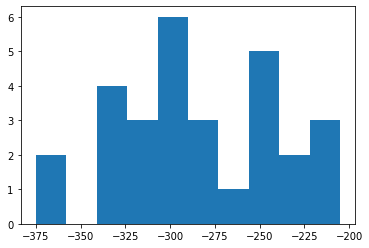

In [254]:
plt.hist(ult[ult['Amount'].between(-400,-200)]['Amount'])

<BarContainer object of 756 artists>

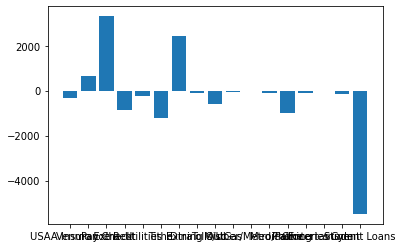

In [195]:
plt.bar(ult['Category'],ult['Amount'])

In [ ]:
plt.plot

In [80]:
ult[['sin_PD_month','cos_PD_month']]

,sin_PD_month,cos_PD_month
0,5.000000e-01,8.660254e-01
1,5.000000e-01,8.660254e-01
2,5.000000e-01,8.660254e-01
3,5.000000e-01,8.660254e-01
4,5.000000e-01,8.660254e-01
5,5.000000e-01,8.660254e-01
6,5.000000e-01,8.660254e-01
7,5.000000e-01,8.660254e-01
8,5.000000e-01,8.660254e-01
9,5.000000e-01,8.660254e-01


<AxesSubplot:xlabel='sin_PD_month', ylabel='cos_PD_month'>

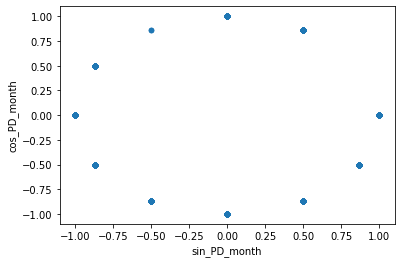

In [83]:
ult.plot.scatter('sin_PD_month','cos_PD_month')

In [93]:
ult_df[ult_df['Content'].str.contains('NAZ',na=False)]

,Purchase Date,Purchase Time,Payment_Method,Content,Amount,Verification Date,Content_Word_Length,First_Word,Last_Word,Middle_Words,Category
143,2020-10-16,16:21:00,POS PURCHASE Non-PIN,NAZRET RESTAURANT 703-3479911 VA768720,-19.79,2020-10-19,5,NAZRET,NA,"['RESTAURANT', '703-3479911', 'VA768720']",Dining Out
154,2020-10-11,00:03:00,POS PURCHASE Non-PIN,NAZRET RESTAURANT 703-3479911 VA768720,-19.79,2020-10-14,5,NAZRET,NA,"['RESTAURANT', '703-3479911', 'VA768720']",Dining Out
202,2020-09-20,07:58:00,POS PURCHASE Non-PIN,SQ *NAZRET ETHIOPIA RES BAILEYS CROSS VAINC300,-20.34,2020-09-21,8,SQ,NA,"['*NAZRET', 'ETHIOPIA', 'RES', 'BAILEYS', 'CROSS', 'VAINC300']",Dining Out
282,2020-08-28,00:50:00,POS PURCHASE Non-PIN,SQ *NAZRET ETHIOPIA RES BAILEYS CROSS VAIN7400,-20.34,2020-08-31,8,SQ,NA,"['*NAZRET', 'ETHIOPIA', 'RES', 'BAILEYS', 'CROSS', 'VAIN7400']",Dining Out
387,2020-07-19,20:55:00,POS PURCHASE Non-PIN,NAZRET ETHIOPIA RESTAUR FALLS CHURCH VAINC800,-24.15,2020-07-21,7,NAZRET,NA,"['ETHIOPIA', 'RESTAUR', 'FALLS', 'CHURCH', 'VAINC800']",Dining Out
733,2020-01-16,11:24:00,POS PURCHASE Non-PIN,NAZRET RESTAURANT 703-3479911 VA768720,-30.51,2021-01-19,5,NAZRET,NA,"['RESTAURANT', '703-3479911', 'VA768720']",Dining Out


In [89]:
ult_df[(ult_df['Category'] == 'Dining Out') & (ult_df['First_Word'] == 'UBER')]

,Purchase Date,Purchase Time,Payment_Method,Content,Amount,Verification Date,Content_Word_Length,First_Word,Last_Word,Middle_Words,Category
33,2020-12-25,04:55:00,POS PURCHASE Non-PIN,UBER EATS HELP.UBER.COM CA IN8200,-18.22,2020-12-28,5,UBER,IN8200,"['EATS', 'HELP.UBER.COM', 'CA']",Dining Out
34,2020-12-24,17:06:00,POS PURCHASE Non-PIN,UBER EATS HELP.UBER.COM CA INB500,-28.02,2020-12-28,5,UBER,INB500,"['EATS', 'HELP.UBER.COM', 'CA']",Dining Out
35,2020-12-24,05:51:00,POS PURCHASE Non-PIN,UBER EATS HELP.UBER.COM CA INP900,-15.93,2020-12-24,5,UBER,INP900,"['EATS', 'HELP.UBER.COM', 'CA']",Dining Out
59,2020-12-18,04:49:00,POS PURCHASE Non-PIN,UBER EATS HELP.UBER.COM CA IN1090,-17.86,2020-12-18,5,UBER,IN1090,"['EATS', 'HELP.UBER.COM', 'CA']",Dining Out
60,2020-12-18,04:49:00,POS PURCHASE Non-PIN,UBER EATS HELP.UBER.COM CA INC600,-15.93,2020-12-18,5,UBER,INC600,"['EATS', 'HELP.UBER.COM', 'CA']",Dining Out
69,2020-12-14,22:45:00,POS PURCHASE Non-PIN,UBER EATS HELP.UBER.COM CA IN0300,-26.98,2020-12-15,5,UBER,IN0300,"['EATS', 'HELP.UBER.COM', 'CA']",Dining Out
86,2020-12-08,05:35:00,POS PURCHASE Non-PIN,UBER EATS HELP.UBER.COM CA IN1200,-15.92,2020-12-08,5,UBER,IN1200,"['EATS', 'HELP.UBER.COM', 'CA']",Dining Out
100,2020-12-04,05:35:00,POS PURCHASE Non-PIN,UBER EATS HELP.UBER.COM CA IN1400,-20.41,2020-12-04,5,UBER,IN1400,"['EATS', 'HELP.UBER.COM', 'CA']",Dining Out
102,2020-12-04,05:35:00,POS PURCHASE Non-PIN,UBER EATS*1 HELP.UBER.COM CA IN7500,-20.41,2020-12-04,5,UBER,IN7500,"['EATS*1', 'HELP.UBER.COM', 'CA']",Dining Out
121,2020-10-26,09:15:00,POS PURCHASE Non-PIN,UBER EATS HELP.UBER.COM CA INB800,-17.51,2020-10-26,5,UBER,INB800,"['EATS', 'HELP.UBER.COM', 'CA']",Dining Out


In [124]:
ult

,Purchase Date,Purchase Time,Payment_Method,Amount,Verification Date,First_Word,Last_Word,Category,sin_PD_month,cos_PD_month
0,2021-01-29,1899-12-30 00:00:00,Other,-187.68,2021-01-29,USAA,Default,USAA Insurance,5.000000e-01,8.660254e-01
1,2021-01-27,1899-12-30 00:00:00,VENMO,669.80,2021-01-27,VENMO/CASHOUTWALTER,Default,Venmo Extra,5.000000e-01,8.660254e-01
2,2021-01-21,1899-12-30 00:00:00,Other,2099.81,2021-01-21,Accenture,J,Pay Check,5.000000e-01,8.660254e-01
3,2021-01-20,1899-12-30 00:00:00,VENMO,-845.00,2021-01-20,VENMO/PAYMENTWALTER,Default,Rent,5.000000e-01,8.660254e-01
4,2021-01-20,1899-12-30 00:00:00,VENMO,-48.22,2021-01-20,VENMO/PAYMENTWALTER,Default,Utilities,5.000000e-01,8.660254e-01
5,2021-01-07,1899-12-30 00:00:00,Other,-339.23,2021-01-07,Pillar,WASHI,Tithe,5.000000e-01,8.660254e-01
6,2021-01-06,1899-12-30 00:00:00,Other,2262.00,2021-01-06,Accenture,J,Pay Check,5.000000e-01,8.660254e-01
7,2021-01-06,1899-12-30 00:00:00,VENMO,-26.12,2021-01-06,VENMO/PAYMENTWALTER,Default,Utilities,5.000000e-01,8.660254e-01
8,2021-01-06,1899-12-30 00:00:00,Other,-60.00,2021-01-06,Pillar,WASHI,Tithe,5.000000e-01,8.660254e-01
9,2021-01-05,1899-12-30 00:00:00,Other,175.00,2021-01-05,Mobile,Default,Extra,5.000000e-01,8.660254e-01


In [ ]:
# once you create that month_year column, groupby month_year and sum amount
# plot the month_year (in order) and the amount to see profitability
# size and label, expand as necessary to create compelling neat image

In [196]:
ult['First_Word'].value_counts()

GIANT                        86
UBER                         80
HARRIS                       55
VENMO/PAYMENTWALTER          37
ARLINGTON                    27
VENMO/CASHOUTWALTER          23
SQ                           22
Accenture                    19
ADVANCED                     18
PAYPAL                       15
Pillar                       15
PP*GOOGLE                    13
FEDLOANSERVICING/STDNT       13
TST*                         13
Person-to-Person             12
TAJ                          10
DISTRICT                      9
COLUMBIA                      8
MCDONALD'S                    8
Tortas                        8
VTG*Emmaus                    8
WASHINGTON                    7
VERIZON/PAYMENTRECWALTER      7
Amazon                        7
USAA                          6
AMZN                          6
STARBUCKS                     6
TOM                           6
ROBINHOOD/FundsWalter         6
POS                           5
CROWNE                        5
FUNDRISE

In [203]:
ult['Payment_Method'].unique()

array(['Other', 'VENMO', 'POS PURCHASE Non-PIN', 'POS PURCHASE with PIN'],
      dtype=object)

In [204]:
ult_df[ult_df['Payment_Method'] != 'VENMO']['Content'].sort_values().unique()

array([' PIZZA IAD STERLING VA 027220', '7-ELEVEN ANNANDALE VA 00M6LQ',
       '7-ELEVEN ARLINGTON VA 00MP57', '7-ELEVEN AUSTIN TX 00MF31',
       '708 BOWLERO ARLINGTON 8 ARLINGTON VA393452 ',
       '708 BOWLERO ARLINGTON 8 ARLINGTON VA501997 ',
       'A-PLUS #74 STERLING VA 127315',
       'ABI AZTECA GRILL 703-9793579 VA766653 ',
       'ABM PARKING BALLSTON ARLINGTON VA952212 ',
       'ACCENTURE FEDERA/EFTWALTER J COLEMAN',
       'ADVANCED HEALTH CARE ARLINGTON VA585367 ',
       'ADVANCED HEALTH CARE ARLINGTON VA589325 ',
       'ADVANCED HEALTH CARE ARLINGTON VA615777 ',
       'ADVANCED HEALTH CARE ARLINGTON VA616655 ',
       'ADVANCED HEALTH CARE ARLINGTON VA616775 ',
       'ADVANCED HEALTH CARE ARLINGTON VA629441 ',
       'ADVANCED HEALTH CARE ARLINGTON VA635033 ',
       'ADVANCED HEALTH CARE ARLINGTON VA648825 ',
       'ADVANCED HEALTH CARE ARLINGTON VA654037 ',
       'ADVANCED HEALTH CARE ARLINGTON VA671232 ',
       'ADVANCED HEALTH CARE ARLINGTON VA671403 ',
    

In [218]:
data_corpus=set()
for row in ult_df['Content']:
    for word in row.split(" "):
        if word not in data_corpus:
            data_corpus.add(word)

data_corpus=sorted(data_corpus)

print(data_corpus)

['', '#', '#02', '#0204', '#0657', '#2647', '#3', '#3289', '#4608', '#648', '#74', '&', '(EAT', '*AIRBNB', '*ATX', '*BJJ', '*CHALAIT', '*CLARENDON', '*COLE', '*COLEMAN', '*COMET', '*DOMAIN', '*EDX', '*ETS', '*HOLEY', '*HOME', '*IDIDOS', '*KENDALL', '*LAS', '*MERCADITO', '*MICROSOFT', '*MYPROTEIN', '*NAZRET', '*RUSTAMKO', '*SAN', '*SOL', '*SPICY', '*THE', '*THREE', '*UDEMY', '*VAN', '*WIRELESS', '-', '000000', '000002', '000007', '0000JY', '000148', '001', '00M6LQ', '00MF31', '00MP57', '010966', '01623192326', '01623319517', '01699062642', '01699064714', '020632', '02142-', '027220', '027750', '047865', '0774', '1', '1100', '1185', '119210', '127315', '132571', '1706', '206-5436049', '20695', '242647', '24498', '261185', '264700', '299648', '3', '310/TAX', '310COLEMAN,', '3110', '3219', '342700342741', '351111', '35314369001', '35314369001GB', '360430', '3705', '380371', '399971', '402-935-7733', '4029357733', '434-2977954', '499850', '504325', '510-214-0212', '517463', '5298', '537198'

In [219]:
len(data_corpus)

864

In [248]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [258]:
def no_space(x):
    if x[-1] == ' ':
        return x[:-1]
    else:
        return x

In [260]:
ult_df['Sentence'] = ult_df['Content'].apply(no_space)

In [261]:
sentences = ult_df['Sentence'].to_list()

In [264]:
tokenizer = Tokenizer(num_words=100, filters=' /*,', lower= 1, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

In [265]:
word_index

{'<OOV>': 1,
 'arlington': 2,
 'va': 3,
 'coleman': 4,
 'ca': 5,
 'giant': 6,
 '0774': 7,
 '001': 8,
 'default': 9,
 'uber': 10,
 'help.uber.com': 11,
 'eats': 12,
 'venmo': 13,
 'harris': 14,
 '#3': 15,
 'teeter': 16,
 'paymentwalter': 17,
 'va999999': 18,
 's': 19,
 '950': 20,
 'parking': 21,
 'walter': 22,
 'of': 23,
 'pillar': 24,
 'va694452': 25,
 'bill': 26,
 'meter': 27,
 'cashoutwalter': 28,
 'washington': 29,
 '402-935-7733': 30,
 'j': 31,
 'dc': 32,
 'sq': 33,
 'accenture': 34,
 'federa': 35,
 'amzn.com': 36,
 'payrll': 37,
 'depcoleman': 38,
 'church': 39,
 'paypal': 40,
 'advanced': 41,
 'health': 42,
 'care': 43,
 'tx': 44,
 'dcpillar': 45,
 'washi': 46,
 '380371': 47,
 'austin': 48,
 'alexandria': 49,
 'new': 50,
 'york': 51,
 'pp': 52,
 'google': 53,
 'tst': 54,
 'the': 55,
 'store': 56,
 'fedloanservicing': 57,
 'stdnt': 58,
 'person-to-person': 59,
 'citgo': 60,
 'columbia': 61,
 '1': 62,
 'trip': 63,
 'r': 64,
 'taj': 65,
 'india': 66,
 'san': 67,
 'loanwalter': 68,
 

In [266]:
sequences = tokenizer.texts_to_sequences(sentences)
print(sentences)
print(word_index)
print(sequences)

['USAA PC/PAYMENTWALTER COLEMAN Default', 'VENMO/CASHOUTWALTER COLEMAN Default', 'Accenture Federa/PAYRLL DEPColeman, Walter J', 'VENMO/PAYMENTWALTER COLEMAN Default', 'VENMO/PAYMENTWALTER COLEMAN Default', 'Pillar DC/Pillar DCPILLAR CHURCH OF WASHI', 'Accenture Federa/PAYRLL DEPColeman, Walter J', 'VENMO/PAYMENTWALTER COLEMAN Default', 'Pillar DC/Pillar DCPILLAR CHURCH OF WASHI', 'Mobile Check Deposit Default', 'Federal Benefit Payment/XXTAXEIP2IRS TREAS 310COLEMAN, WALTER J', "MCDONALD'S F4976 MECHANICSVILL VA1", 'EL PULGARCITO RESTAURAN ALEXANDRIA VA063886', 'MIDAS. ARLINGTON VA 399971', 'AUTOZONE 5298 3705 MT ALEXANDRIA VA999999', 'COLUMBIA PIKE CITGO ARLINGTON VA10', 'ARLINGTON ME TER PARKING ARLINGTON VA694452', 'ARLINGTON METER PARKING ARLINGTON VA694452', 'ATM WD FEE L48155WILLYS BARBE- 3219 COLUMBIA ARLINGTON VA', 'SK EYECARE ARLINGTON VA 499850', 'ATM WITHDRAWALWILLYS BARBE- 3219 COLUMBIA ARLINGTON VAL48155', 'EL CUSCATLECO RESTAURAN ALEXANDRIA VA791732', 'TAQUERIA SENORA LOL

In [267]:
# pre padding
pre_pad = pad_sequences(sequences, padding='pre')
print("\nword_index = ", word_index)
print("\nsequences = ", sequences)
print("\npadded_seq = " )
print(pre_pad)


word_index =  {'<OOV>': 1, 'arlington': 2, 'va': 3, 'coleman': 4, 'ca': 5, 'giant': 6, '0774': 7, '001': 8, 'default': 9, 'uber': 10, 'help.uber.com': 11, 'eats': 12, 'venmo': 13, 'harris': 14, '#3': 15, 'teeter': 16, 'paymentwalter': 17, 'va999999': 18, 's': 19, '950': 20, 'parking': 21, 'walter': 22, 'of': 23, 'pillar': 24, 'va694452': 25, 'bill': 26, 'meter': 27, 'cashoutwalter': 28, 'washington': 29, '402-935-7733': 30, 'j': 31, 'dc': 32, 'sq': 33, 'accenture': 34, 'federa': 35, 'amzn.com': 36, 'payrll': 37, 'depcoleman': 38, 'church': 39, 'paypal': 40, 'advanced': 41, 'health': 42, 'care': 43, 'tx': 44, 'dcpillar': 45, 'washi': 46, '380371': 47, 'austin': 48, 'alexandria': 49, 'new': 50, 'york': 51, 'pp': 52, 'google': 53, 'tst': 54, 'the': 55, 'store': 56, 'fedloanservicing': 57, 'stdnt': 58, 'person-to-person': 59, 'citgo': 60, 'columbia': 61, '1': 62, 'trip': 63, 'r': 64, 'taj': 65, 'india': 66, 'san': 67, 'loanwalter': 68, 'pike': 69, 'amazon.com': 70, 'district': 71, 'martia

In [268]:
post_pad = pad_sequences(sequences, padding='post')
print("\nword_index = ", word_index)
print("\nsequences = ", sequences)
print("\npadded_seq = " )
print(post_pad)


word_index =  {'<OOV>': 1, 'arlington': 2, 'va': 3, 'coleman': 4, 'ca': 5, 'giant': 6, '0774': 7, '001': 8, 'default': 9, 'uber': 10, 'help.uber.com': 11, 'eats': 12, 'venmo': 13, 'harris': 14, '#3': 15, 'teeter': 16, 'paymentwalter': 17, 'va999999': 18, 's': 19, '950': 20, 'parking': 21, 'walter': 22, 'of': 23, 'pillar': 24, 'va694452': 25, 'bill': 26, 'meter': 27, 'cashoutwalter': 28, 'washington': 29, '402-935-7733': 30, 'j': 31, 'dc': 32, 'sq': 33, 'accenture': 34, 'federa': 35, 'amzn.com': 36, 'payrll': 37, 'depcoleman': 38, 'church': 39, 'paypal': 40, 'advanced': 41, 'health': 42, 'care': 43, 'tx': 44, 'dcpillar': 45, 'washi': 46, '380371': 47, 'austin': 48, 'alexandria': 49, 'new': 50, 'york': 51, 'pp': 52, 'google': 53, 'tst': 54, 'the': 55, 'store': 56, 'fedloanservicing': 57, 'stdnt': 58, 'person-to-person': 59, 'citgo': 60, 'columbia': 61, '1': 62, 'trip': 63, 'r': 64, 'taj': 65, 'india': 66, 'san': 67, 'loanwalter': 68, 'pike': 69, 'amazon.com': 70, 'district': 71, 'martia

In [281]:
prepad_maxlen_pretrunc = pad_sequences(sequences, padding = 'pre', maxlen =10, truncating = 'pre')
print(prepad_maxlen_pretrunc)

[[ 0  0  0 ... 17  4  9]
 [ 0  0  0 ... 28  4  9]
 [ 0  0  0 ... 38 22 31]
 ...
 [ 0  0  0 ...  1  2  1]
 [ 0  0  0 ...  1  1  1]
 [ 0  0  0 ... 19  2 18]]


In [282]:
# pre padding, maxlen and post truncation
prepad_maxlen_posttrunc = pad_sequences(sequences, padding = 'pre', maxlen =10, truncating = 'post')
print(prepad_maxlen_posttrunc)

[[ 0  0  0 ... 17  4  9]
 [ 0  0  0 ... 28  4  9]
 [ 0  0  0 ... 38 22 31]
 ...
 [ 0  0  0 ...  1  2  1]
 [ 0  0  0 ...  1  1  1]
 [ 0  0  0 ... 19  2 18]]


In [1]:
lis = [1,2,3,4]

In [10]:
sorted(lis)[:-5:-1]

[4, 3, 2, 1]